In [ ]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from pytorch_lightning.callbacks import EarlyStopping


import time

import numpy as np

import matplotlib.pyplot as plt

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [3]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')


train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_dataset = TimeSeriesDataSet(stock_data[stock_data.time_idx <= train_cutoff], **common_params)
val_dataset = TimeSeriesDataSet(stock_data[stock_data.time_idx > train_cutoff], **common_params)

train_dataloader = train_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            # Prepare LSTM Data
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            val_X, val_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))

            # Build Model
            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=15, batch_size=20, 
                    verbose=1, validation_split=0.1,)

            # Training Evaluation
            train_pred = lstm_model.predict(train_X)
            train_rmse = mean_squared_error(train_y, train_pred)

            # Validation Evaluation
            val_pred = lstm_model.predict(val_X)
            val_rmse = mean_squared_error(val_y, val_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            lstm_model.save('models/lstm_model_base.keras')
        
        elif model_name == "N-BEATS":
            # PyTorch Forecasting Models
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4], 
                num_block_layers=[4,4],
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader)

            # Training Evaluation
            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            # Validation Evaluation
            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = nbeats_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = nhits_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()


            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = transformer_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Val RMSE: {rmse_values['val_rmse']:.4f}")



=== Training LSTM_Keras ===
Epoch 1/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0298 - val_loss: 0.0760
Epoch 2/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0056 - val_loss: 0.0707
Epoch 3/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0052 - val_loss: 0.0673
Epoch 4/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0051 - val_loss: 0.0615
Epoch 5/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0050 - val_loss: 0.0592
Epoch 6/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0049 - val_loss: 0.0578
Epoch 7/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0047 - val_loss: 0.0521
Epoch 8/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - val_loss: 0.0538
Epoch 9/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0046 - val_loss: 0.0541
Epoch 10/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0045 - val_loss: 0.0549
Epoch 11/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0045 - val_loss: 0.0493
Epoch 12/15


2025/11/03 19:51:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 19:51:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/03 19:51:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
G

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/0/runs/6161441ce4dd4d6eb2695f3080c3d323
🧪 View experiment at: http://localhost:5000/#/experiments/0

=== Training N-BEATS ===
Epoch 1:   3%|▎         | 4/148 [00:00<00:07, 19.98it/s, train_loss_step=4.040, train_loss_epoch=4.120]  

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 148/148 [00:07<00:00, 20.07it/s, train_loss_step=4.100, train_loss_epoch=3.880]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 148/148 [00:07<00:00, 20.07it/s, train_loss_step=4.100, train_loss_epoch=3.880]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:111: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:116: DeprecationWarning: __array_wrap__ must accept contex

🏃 View run N-BEATS at: http://localhost:5000/#/experiments/0/runs/edadd016aa934dfe88a4b81576bffe0d
🧪 View experiment at: http://localhost:5000/#/experiments/0

=== Training N-HITS ===
Epoch 19: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s, train_loss_step=3.470, train_loss_epoch=3.840]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s, train_loss_step=3.470, train_loss_epoch=3.840]


C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:146: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:151: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()
2025/11/03 19:56:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 19:56:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0

🏃 View run N-HITS at: http://localhost:5000/#/experiments/0/runs/9cf2f68497c4481ca7c6bdd61764b8c4
🧪 View experiment at: http://localhost:5000/#/experiments/0

=== Training Transformer ===
Epoch 19: 100%|██████████| 148/148 [00:12<00:00, 11.93it/s, train_loss_step=0.0235, train_loss_epoch=0.0257]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 148/148 [00:12<00:00, 11.93it/s, train_loss_step=0.0235, train_loss_epoch=0.0257]


C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:178: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
C:\Users\veres\AppData\Local\Temp\ipykernel_1964\1268485622.py:184: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()
2025/11/03 20:00:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 20:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/0/runs/e4a3674e10d440d4b520fd7a798cd6bd
🧪 View experiment at: http://localhost:5000/#/experiments/0

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0089, Val RMSE: 1.4374
N-BEATS => Train RMSE: 0.7037, Val RMSE: 0.2068
N-HITS => Train RMSE: 0.6955, Val RMSE: 0.2051
Transformer => Train RMSE: 0.6971, Val RMSE: 0.2140


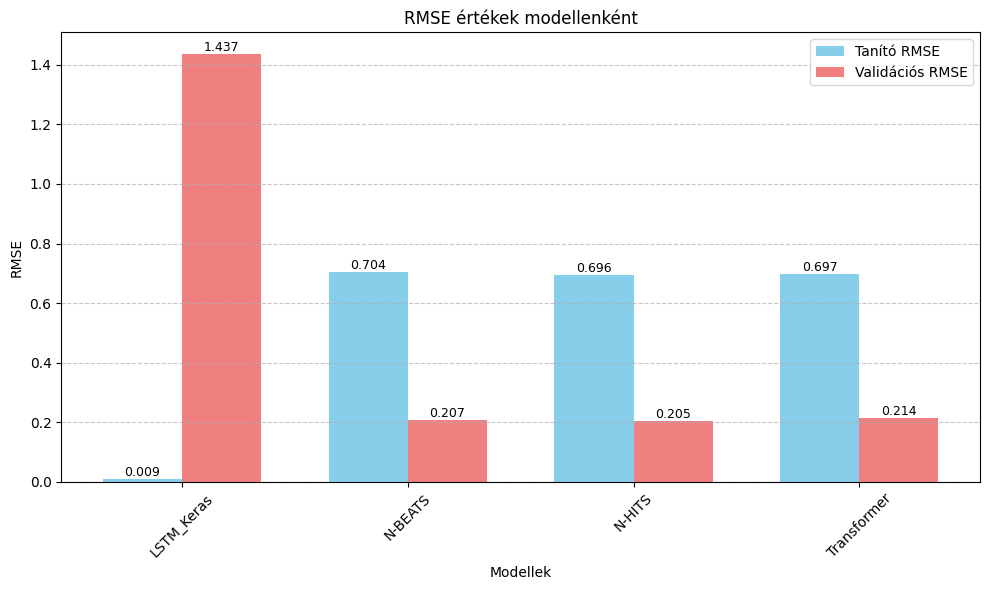

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['val_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Validációs RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' doe

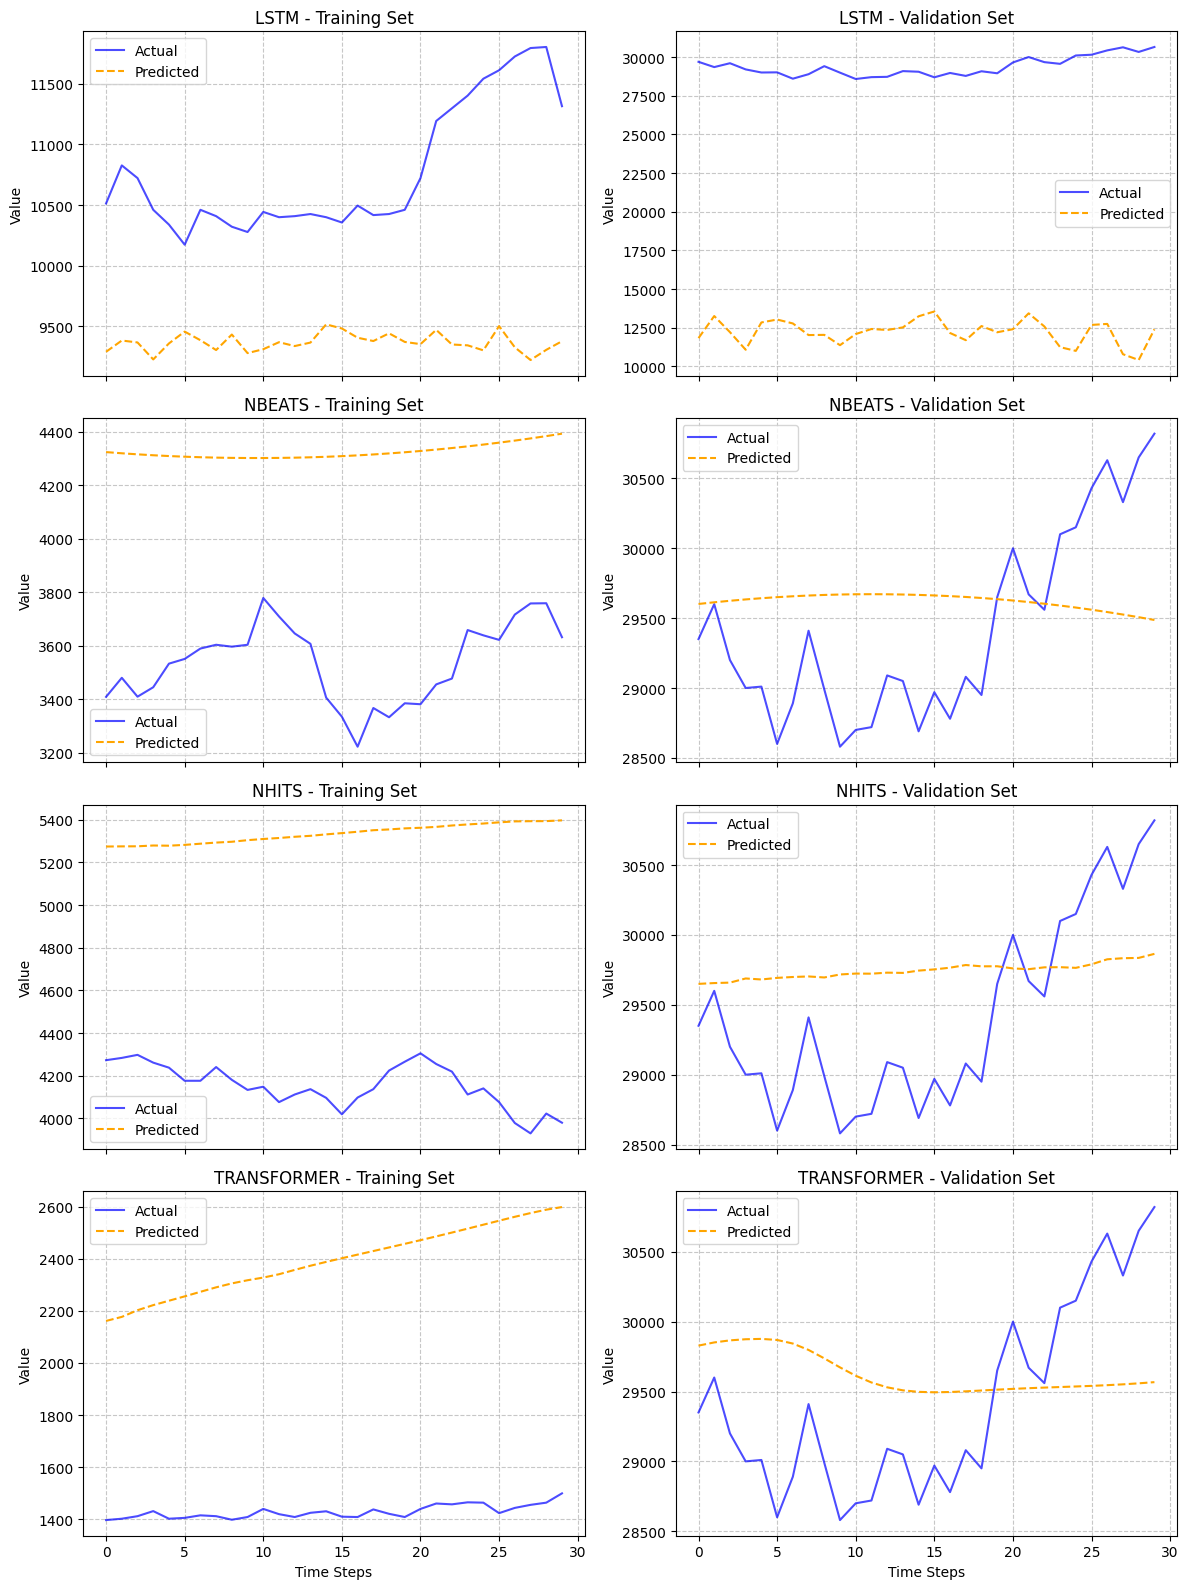

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

train_predictions = {}
val_predictions = {}
train_actuals = {}
val_actuals = {}

for name in model_names:
    if name == "lstm":
        train_pred = lstm_model.predict(train_X)
        val_pred = lstm_model.predict(val_X)
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        val_predictions[name] = scaler.inverse_transform(val_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        val_actuals[name] = scaler.inverse_transform(val_y)[-1]
    else:
        model = model_names[name]
        train_pred = model.predict(train_dataloader).detach().numpy()
        val_pred = model.predict(val_dataloader).detach().numpy()
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        val_actual = torch.cat([y[0] for x, y in iter(val_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        val_predictions[name] = scaler.inverse_transform(val_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        val_actuals[name] = scaler.inverse_transform(val_actual)[-1]

fig, axes = plt.subplots(len(model_names), 2, figsize=(12, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):
    # Training set plot
    axes[idx][0].plot(train_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][0].plot(train_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][0].set_title(f'{name.upper()} - Training Set')
    axes[idx][0].set_ylabel('Value')
    axes[idx][0].legend()
    axes[idx][0].grid(True, linestyle='--', alpha=0.7)

    # Validation set plot
    axes[idx][1].plot(val_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][1].plot(val_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][1].set_title(f'{name.upper()} - Validation Set')
    axes[idx][1].set_ylabel('Value')
    axes[idx][1].legend()
    axes[idx][1].grid(True, linestyle='--', alpha=0.7)

for ax in axes[-1]:
    ax.set_xlabel('Time Steps')
plt.tight_layout()

plt.show()

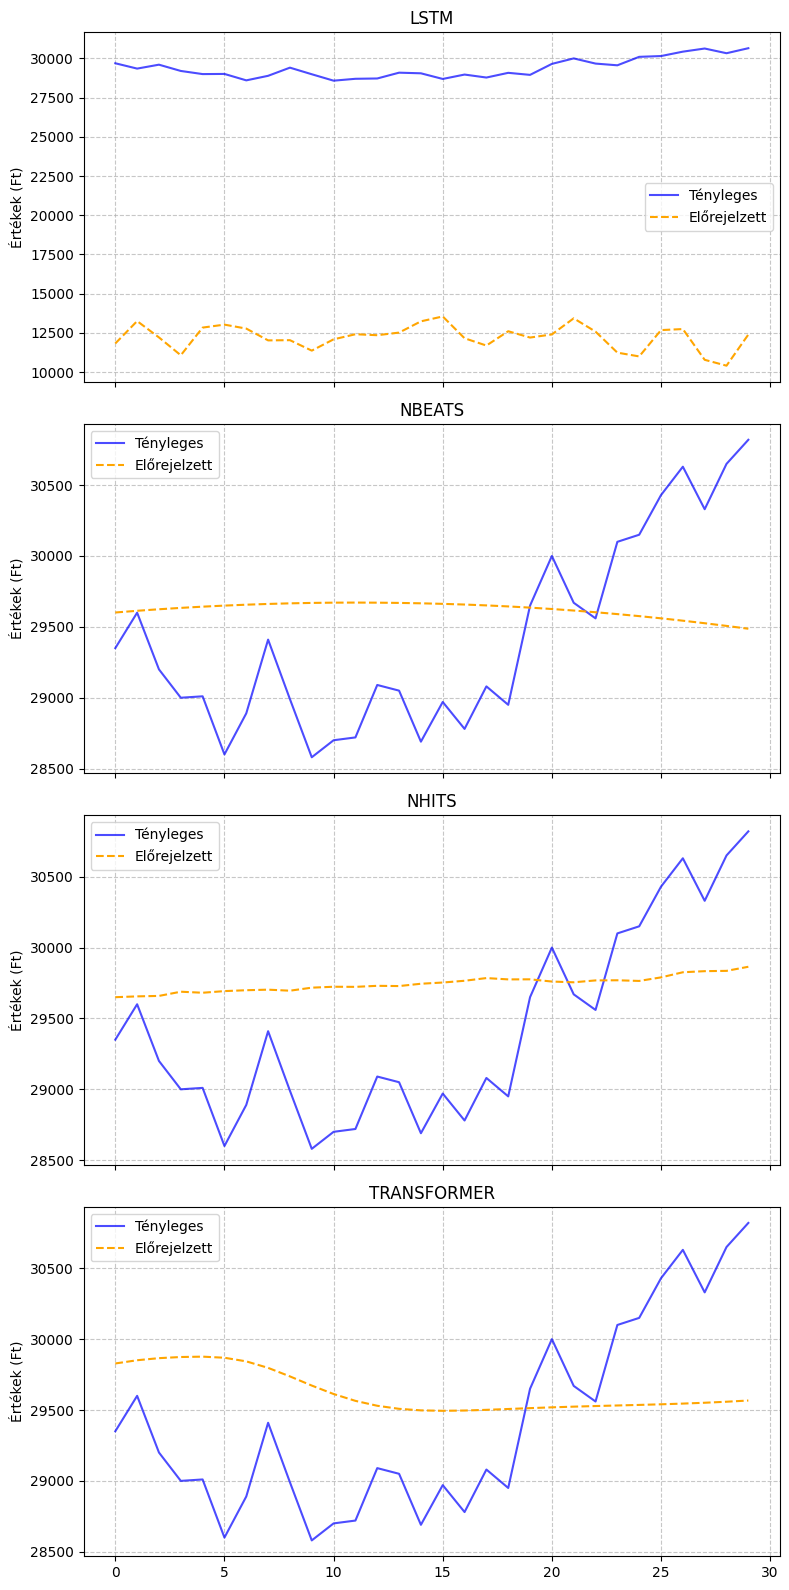

In [25]:
fig, axes = plt.subplots(len(model_names), 1, figsize=(8, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):

    axes[idx].plot(val_actuals[name], label='Tényleges', color='blue', alpha=0.7)
    axes[idx].plot(val_predictions[name], label='Előrejelzett', color='orange', linestyle='--')
    axes[idx].set_title(f'{name.upper()}')
    axes[idx].set_ylabel('Értékek (Ft)')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

# Tanítás hírek használatával

In [27]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from pytorch_lightning.callbacks import EarlyStopping


import time

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [29]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')


train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 50
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["sentiment_score"] 

train_dataset = TimeSeriesDataSet(stock_data[stock_data.time_idx <= train_cutoff], **common_params)
val_dataset = TimeSeriesDataSet(stock_data[stock_data.time_idx > train_cutoff], **common_params)

train_dataloader = train_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            val_X, val_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=15, batch_size=20, 
                    verbose=1, validation_split=0.1,)

            train_pred = lstm_model.predict(train_X)
            train_rmse = mean_squared_error(train_y, train_pred)

            val_pred = lstm_model.predict(val_X)
            val_rmse = mean_squared_error(val_y, val_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            lstm_model.save('models/lstm_model_base.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],    
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4],  
                num_block_layers=[4,4],  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = nbeats_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = nhits_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()


            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            val_predictions = transformer_model.predict(val_dataloader)
            val_rmse = np.sqrt(torch.mean((val_actuals - val_predictions[:len(val_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Val RMSE: {rmse_values['val_rmse']:.4f}")
